## Importing the libraries

In [2]:
import torch
import numpy as np
import cv2
import json
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from google.colab.patches import cv2_imshow
from torchvision import models
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the Data

In [4]:
def loadImages(directory):
  data = []
  for file in sorted(os.listdir(directory)):
      img_path = os.path.join(directory, file)
      if (file != 'imgCoordinates.json'):
        img = cv2.imread(img_path)
        img[np.all(img == (255,255,255), axis=-1)] = (0,0,255)
        img[np.all(img == (100,100,100), axis=-1)] = (255,0,0)
        img[np.all(img == (0,0,0), axis=-1)] = (0,255,0)
        img = cv2.resize(img, (224,224))
        data.append(img)

  #cv2_imshow(data[126])
  return data

# data = loadImages('/content/drive/MyDrive/newDatabase')
# data = np.array(data)

# trainImages = np.array(data)
# print(data.shape)

In [5]:

def loadLabels(directory, jsonFile):
  data = []
  jsonDictionary = {}

  with open(os.path.join(directory, jsonFile), 'r') as js:
    json_data = js.read()

  jsonDictionary = json.loads(json_data)

  for file in sorted(os.listdir(directory)):
    if (file != 'imgCoordinates.json'):
      entry = jsonDictionary["database/"+file]
      values = entry.strip('()')
      values = values.split(',')
      values = [int(int(val)*224/400) for val in values]
      values = np.array(values)
      data.append(values)

  return data
# data = loadLabels('/content/drive/MyDrive/newDatabase', 'imgCoordinates.json')

# trainLabels = np.array(data)
# trainLabels = (trainLabels)/400
# print(trainLabels.shape)
# print(trainLabels[11])

## Augmenting the data

In [6]:
def rotateImage(angle, image):
  rad = math.radians(angle)
  center = (image.shape[1] // 2, image.shape[0] // 2)  # Center of the image

  # Get the rotation matrix
  rotationMatrix = cv2.getRotationMatrix2D(center, angle, 1.0)

  # Rotate the image
  rotatedImage = cv2.warpAffine(image, rotationMatrix, (image.shape[1], image.shape[0]))
  return rotatedImage

def rotatePoint(center, point, angle):
  s = math.sin(angle)
  c = math.cos(angle)

  pointNew = point[0] - center[0], point[1] - center[1];
  pointNew = pointNew[0] * c - pointNew[1] * s, pointNew[0] * s + pointNew[1] * c;
  pointNew = int(pointNew[0] + center[0]), int(pointNew[1] + center[1])
  return pointNew;

In [7]:
imgData = loadImages('/content/drive/MyDrive/newDatabase')
imgData = np.array(imgData)
labelData = loadLabels('/content/drive/MyDrive/newDatabase', 'imgCoordinates.json')
labelData  = np.array(labelData)
print(labelData[0])

[96 32]


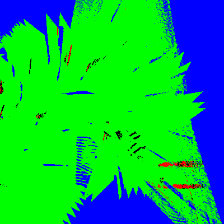

array([208, 174])

In [9]:
# cv2.circle(imgData[3], (labelData[3][0], labelData[3][1]), 5, (255,0,255), -1)
cv2_imshow(imgData[3])
labelData = np.array(labelData)
labelData[3]

In [14]:
augmentedImages = []
augmentedLabels = []

OFFSET = 180
displayImages = []
displayLabels = []

for angle in range(0,360, OFFSET):
  firstSet = True
  print(f"getting rotated by an angle of {angle} degree")
  for image in imgData:
    rotatedImage = rotateImage(angle, image)
    if firstSet == True:
      firstSet = False
      displayImages.append(rotatedImage)
    augmentedImages.append(rotatedImage)
augmentedImages = np.array(augmentedImages)

min_val = np.min(augmentedImages)
max_val = np.max(augmentedImages)

trainImages = (augmentedImages - min_val) / (max_val - min_val)

augmentedImages.shape

getting rotated by an angle of 0 degree
getting rotated by an angle of 180 degree


(722, 224, 224, 3)

In [15]:
for angle in range(0,360, OFFSET):
  firstSet = True
  rad = np.radians(angle)  # Rotate by 45 degrees
  rotationMatrix = np.array([[np.cos(rad), -np.sin(rad)],
                            [np.sin(rad), np.cos(rad)]])
  labelDataOriginShifted = labelData -112
  rotatedLabels = np.dot(labelDataOriginShifted, rotationMatrix)
  rotatedLabels = rotatedLabels + 112
  rotatedLabels = np.round(rotatedLabels)
  displayLabels.append(rotatedLabels[0])
  augmentedLabels.append(rotatedLabels)
displayLabels = np.array(displayLabels)
displayLabels = displayLabels.astype(np.uint8)

augmentedLabels = np.array(augmentedLabels)
augmentedLabels = augmentedLabels.reshape(augmentedLabels.shape[0]*augmentedLabels.shape[1],augmentedLabels.shape[2])
augmentedLabels = augmentedLabels/400

In [16]:
# points = np.array([[1, 0], [0, 1], [2, 2]])
# rad = np.radians(0)  # Rotate by 45 degrees
# rotationMatrix = np.array([[np.cos(rad), -np.sin(rad)],
#                           [np.sin(rad), np.cos(rad)]])
# points = np.dot(points, rotationMatrix)
# points = np.round(points, decimals=2)
# points
# augmentedLabels = np.array(augmentedLabels)
# augmentedLabels.shape

# x = np.array([[[1,2],[2,4]],[[1,2],[2,4]], [[1,2],[2,4]] ])
# x = x.reshape(x.shape[0]*x.shape[1], x.shape[2])
# x

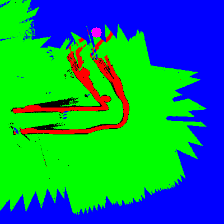

In [17]:

cv2.circle(displayImages[0], displayLabels[0], 5, (255,0,255), -1)
cv2_imshow(displayImages[0])

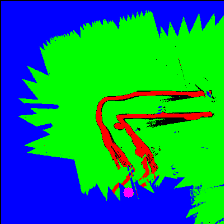

In [18]:
cv2.circle(displayImages[1], displayLabels[1], 5, (255,0,255), -1 )
cv2_imshow(displayImages[1])

In [ ]:
cv2.circle(displayImages[2], displayLabels[2], 5, (255,0,255), -1 )
cv2_imshow(displayImages[2])

In [ ]:
cv2.circle(displayImages[3], displayLabels[3], 5, (255,0,255), -1 )
cv2_imshow(displayImages[3])

In [19]:
class mapDataset(Dataset):

  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    imgSample = self.images[index]
    labelSample = self.labels[index]
    return [imgSample, labelSample]

In [22]:
dataset = mapDataset(augmentedImages, augmentedLabels)
#361 images
print(augmentedLabels.shape[0]*0.75, 0.25*augmentedLabels.shape[0])
train, test = torch.utils.data.random_split(dataset, [658, 64])

trainDl = torch.utils.data.DataLoader(train, batch_size=32)
testDl = torch.utils.data.DataLoader(test, batch_size=32)

541.5 180.5


## Creating the architecture

In [23]:
mobileNetPretrained = models.mobilenet_v2(pretrained=True)
num_classes = 2
mobileNetPretrained.classifier = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(mobileNetPretrained.last_channel, num_classes)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 73.9MB/s]


## Creating the criteria for evaluation

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mobileNetPretrained.parameters(), lr=0.00015)

## Training the Data

In [25]:
EPOCHS = 8
model = mobileNetPretrained
losses=[]

for epoch in range(EPOCHS):
  runningLoss = 0
  for i, (inputs, targets) in enumerate(trainDl):
    optimizer.zero_grad()
    inputs = inputs.to(torch.float32)
    inputs = inputs.view((inputs.shape[0], inputs.shape[3],inputs.shape[2],inputs.shape[1]))
    yhat = model(inputs)
    targets = targets.to(torch.float32)
    loss = criterion(yhat, targets)
    loss.backward()
    optimizer.step()
    runningLoss += loss.item()
    print(f"{((i+1) / len(trainDl))*100} / 100 of epoch")
  losses.append(runningLoss)
  print("----------")
  print(f"LOSS: {runningLoss/len(trainDl) }")
  print(f"{epoch+1} / {EPOCHS} epochs")
  print("-----------")

print("completed training :)")

4.761904761904762 / 100 of epoch
9.523809523809524 / 100 of epoch
14.285714285714285 / 100 of epoch
19.047619047619047 / 100 of epoch
23.809523809523807 / 100 of epoch
28.57142857142857 / 100 of epoch
33.33333333333333 / 100 of epoch
38.095238095238095 / 100 of epoch
42.857142857142854 / 100 of epoch
47.61904761904761 / 100 of epoch
52.38095238095239 / 100 of epoch
57.14285714285714 / 100 of epoch
61.904761904761905 / 100 of epoch
66.66666666666666 / 100 of epoch
71.42857142857143 / 100 of epoch
76.19047619047619 / 100 of epoch
80.95238095238095 / 100 of epoch
85.71428571428571 / 100 of epoch
90.47619047619048 / 100 of epoch
95.23809523809523 / 100 of epoch
100.0 / 100 of epoch
----------
LOSS: 0.17659437017781393
1 / 8 epochs
-----------
4.761904761904762 / 100 of epoch
9.523809523809524 / 100 of epoch
14.285714285714285 / 100 of epoch
19.047619047619047 / 100 of epoch
23.809523809523807 / 100 of epoch
28.57142857142857 / 100 of epoch
33.33333333333333 / 100 of epoch
38.09523809523809

## Evaluating the data

In [26]:
model.eval()
# 4. Forward Pass and Calculate Metrics
correct = 0
total = 0
predictions = []
images = []
with torch.no_grad():
    runningLoss = 0
    for i, (inputs, targets) in enumerate(testDl):
        inputs = inputs.to(torch.float32)
        images.append(inputs.numpy())
        inputs = inputs.view((inputs.shape[0], inputs.shape[3],inputs.shape[2],inputs.shape[1]))
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        runningLoss += loss
        predictions.append(outputs.numpy())
        print(f"LOSS: {runningLoss/len(testDl)}")

images = np.array(images)
images = images*255
images = images[0]
images = images.astype(np.uint8)

LOSS: 0.0021074019618440415
LOSS: 0.0047264099506818345


In [35]:
predictions = np.array(predictions)
#print(predictions)

In [36]:
temp = predictions.tolist()
predictions = []

for block in temp:
  for x in block:
    predictions.append(x)

predictions = np.array(predictions)
predictions.shape

(128,)

## Visualizations

<ipython-input-29-ccc367dd18a0>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(test)


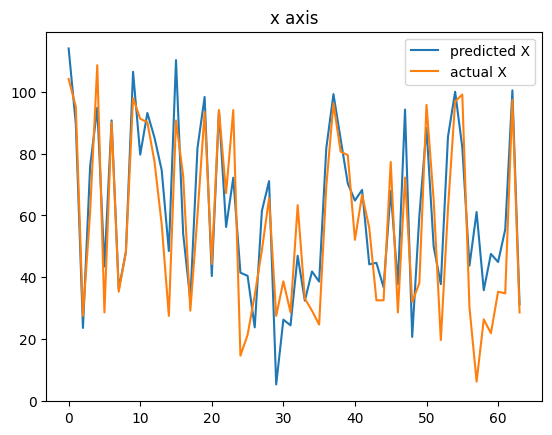

In [29]:
test = np.array(test)
testLabels = test[:, 1]
testX = [cell[0]*224 for cell in testLabels]
testY = [cell[1]*224 for cell in testLabels]
predictionsX = predictions[:,0].flatten()*224
predictionsY = predictions[:,1].flatten()*224
plt.plot(predictionsX, label='predicted X')
plt.plot(testX, label='actual X')
plt.title("x axis")
plt.legend()

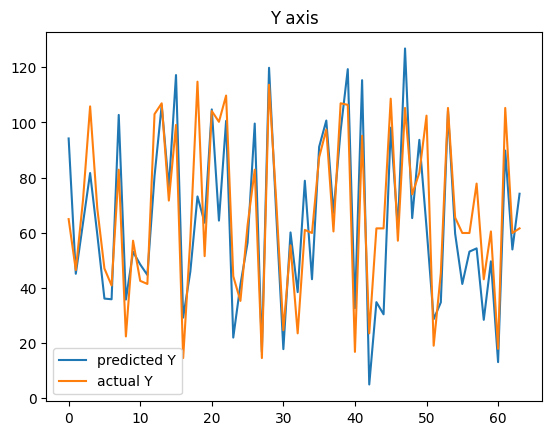

In [30]:
plt.plot(predictionsY, label='predicted Y')
plt.plot(testY, label='actual Y')
plt.title("Y axis")
plt.legend()

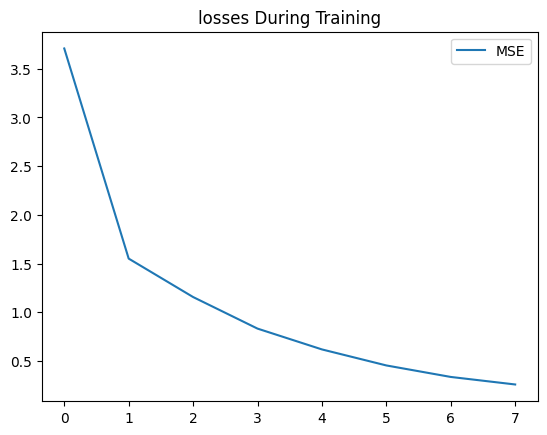

In [31]:
plt.plot(losses, label='MSE')
plt.title("losses During Training")
plt.legend()

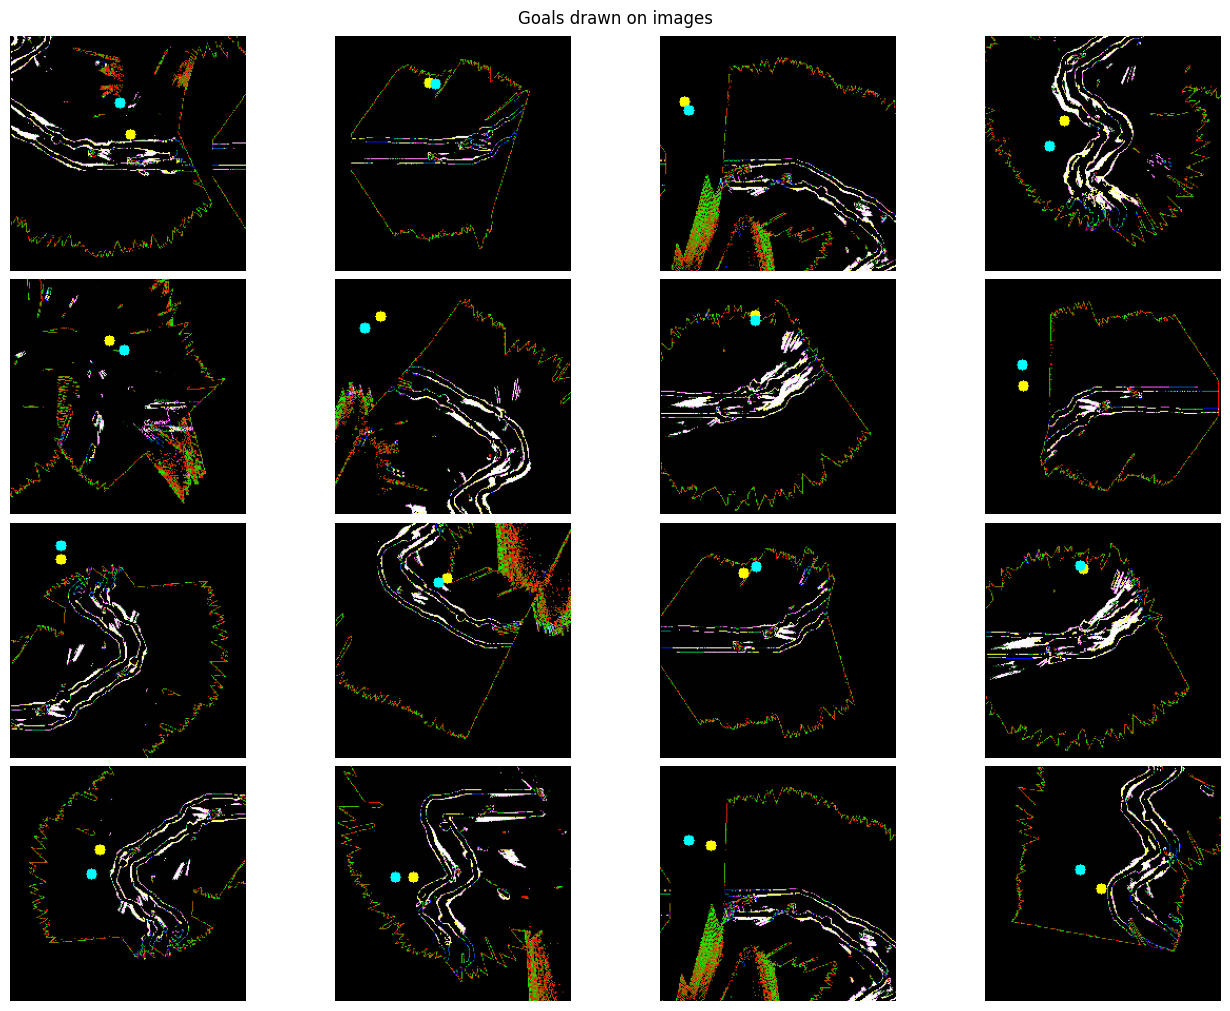

In [32]:
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(13, 10), constrained_layout=True)

#labelling the predictions on the image
yellow = (255,255,0)
white = (0,255,255)
for i in range(32):
  cv2.circle(images[i], (int(predictionsX[i]), int(predictionsY[i])), 5, yellow, -1)
  cv2.circle(images[i], (int(testX[i]), int(testY[i])), 5, white, -1)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
    ax.axis('off')

fig.suptitle('Goals drawn on images')
plt.show()

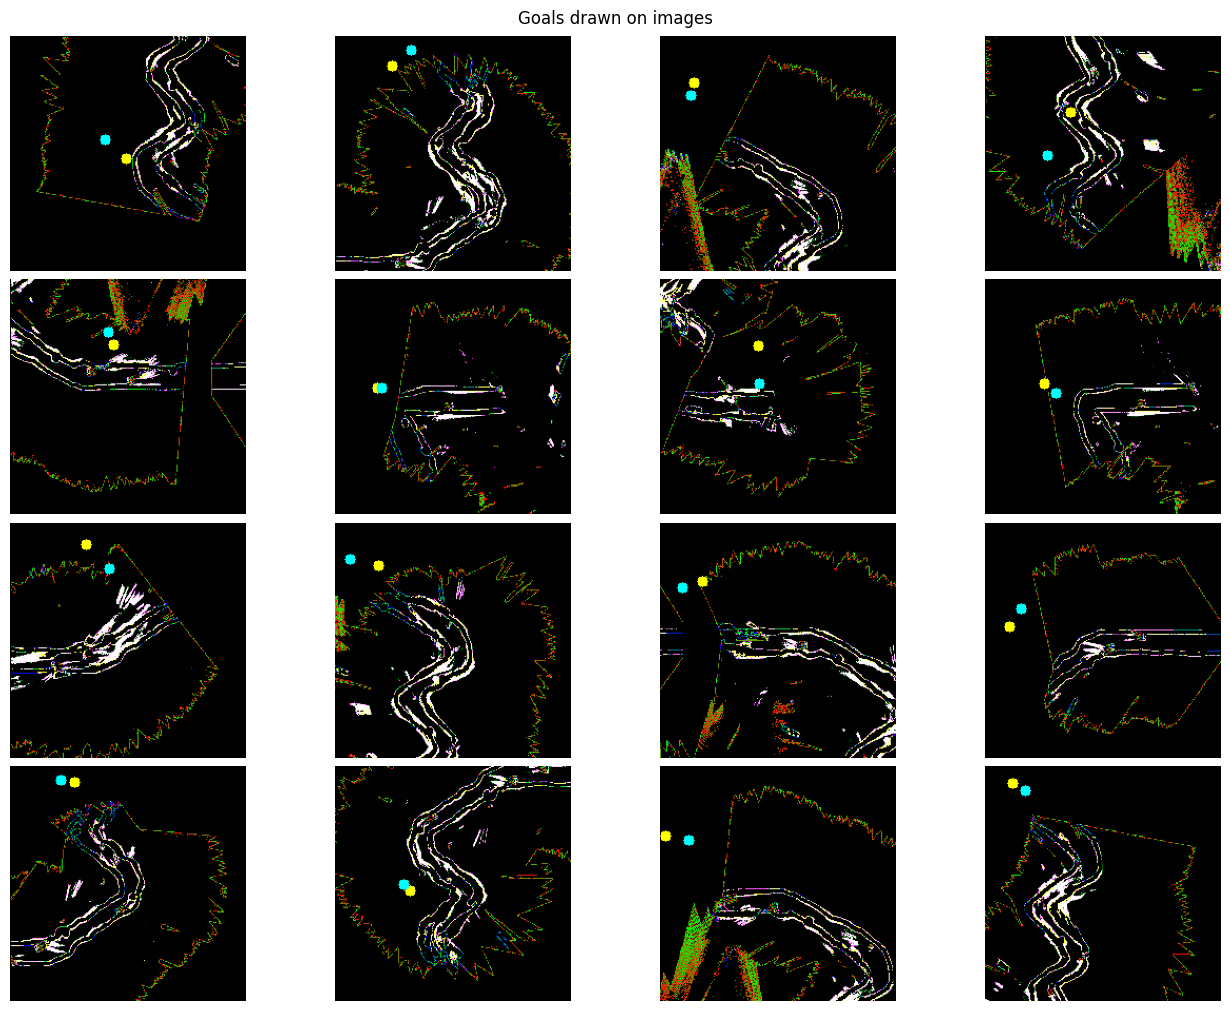

In [33]:
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(13, 10), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i+15 < len(images):
        ax.imshow(images[i+15])
    ax.axis('off')

fig.suptitle('Goals drawn on images')
plt.show()

In [37]:
torch.save(model.state_dict(), "mobileNetV2GoalGeneration6.pth")

##Validation